# Flow-Shop Scheduling

In [98]:
import pandas as pd
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import copy
import random
from random import shuffle, randrange, getrandbits
import itertools
from datetime import datetime
import os
from pathlib import Path
import time

In [2]:
def get_problem(filepath):
    with open(filepath) as f:
        firstline = f.readline().rstrip()
        nums = firstline.split(" ")     
    data = pd.read_csv(filepath, sep= " ", header=None, skiprows=1)
    return data, nums

def df_to_schedule(data, nums, solution = None):
    data = data.to_numpy()
    jobs = []
    for i,row in enumerate(data):
        jobs.append(Job(row, i+1))
        
    # Reorder jobs in certain order
    # Can be used for checking solutions
    if solution:
        temp = [0] * len(solution)
        for i, job_num in enumerate(solution):
            temp[i] = jobs[job_num-1]
        jobs = temp
        
    schedule = Schedule(jobs, int(nums[1]))
    return schedule
    

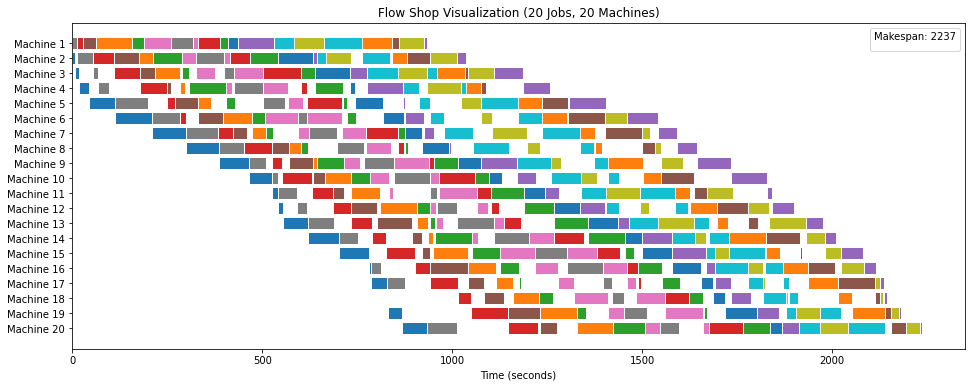

2237


In [144]:
df, nums = get_problem("dataset/ta029.txt")
s = df_to_schedule(df, nums, [1,8,14,6,2,13,7,18,17,4,3,11,15,20,9,10,12,16,19,5,])
s.gantt_chart()

In [22]:
df, nums = get_problem("dataset/ta030.txt")
makespan_list = []
best = None
best_t = 10000000
for i in range(500):
    s = df_to_schedule(df, nums)
    s.randomPermutation()
    s.update_times()
    makespan_list.append(s.makespan())
    if (s.makespan() < best_t):
        print(s.makespan())
        best_t = s.makespan()
        best = s

        


makespan_hist(makespan_list)

AttributeError: 'Schedule' object has no attribute 'randomPermutation'

In [12]:
def gantt_chart(schedule):
#     c_dict = {1:'red', 2:'blue', 3: 'yellow', 4:'green', 5: "orange", 6: "black", 7:"purple", 8: "grey"}
#     def color(row):
#         return c_dict[row['job']]
    df = schedule.get_df()
#     df['color'] = df.apply(color, axis=1)
#     legend_elements = [Patch(facecolor=c_dict[i], label=i)  for i in c_dict]
    df['width'] = (df.end-df.start)
    fig, ax = plt.subplots(1, figsize=(16,6))
    df = df.reset_index()  # make sure indexes pair with number of rows
    for index, row in df.iterrows():
        ax.barh(row['machine'], row['width'], left=row['start'], edgecolor='white')
#     plt.legend(handles=legend_elements)
    plt.show()
    print(schedule.makespan())

In [4]:
def iteration_vs_makespan(makespan_list):
    x = [x for x in range(1, len(makespan_list) +1)]
    plt.scatter(x, makespan_list)

In [5]:
def makespan_hist(makespan_list):
    binwidth = 4
    plt.hist(makespan_list, linewidth=2,
             edgecolor='white')
    plt.show()

In [103]:
df, nums = get_problem("dataset/ta001.txt")
s1 = df_to_schedule(df, nums)
s2 = df_to_schedule(df, nums)
s2.randomize()
s3 = df_to_schedule(df, nums)
s3.randomize()

print(len(set([s1, s2, s3])))

# s1.set_permutation()
# print(s1.jobs)
# s2 = df_to_schedule(df, nums)
# s2.randomize()
# print(s2.jobs)

# child = GA.tp_cross(s1, s2)


3


In [23]:
brute_force("dataset/ta001.txt", 1000)

New Best Makespan: 30148
...
30168
...
30208


KeyboardInterrupt: 

In [ ]:
df, nums = get_problem("dataset/ta001.txt")
initial_pop = [df_to_schedule(df, nums) for x in range(pop_size)]

In [21]:
def brute_force(data, bound):
    if isinstance(data, str):
        df, nums = get_problem(data)
        schedule = df_to_schedule(df, nums)
        jobs = schedule.jobs
    else:
        jobs = data
    
    best_makespan = 1000000000
    best_schedule = None
    bound_check = 1
    for job_order in itertools.permutations(jobs):
        s = Schedule(job_order, len(jobs[0].tasks))
        if(bound_check % 100 == 0):
            print("...")
            print(s.makespan())
        if(s.makespan() < best_makespan):
            best_makespan = s.makespan()
            print(f"New Best Makespan: {best_makespan}")
            best_schedule = s
        if bound_check >= bound:
            break
        bound_check += 1
        
    return best_schedule

In [3]:
def write_results(data, hist, pop_size, mutation_rate, crossover_rate):
    if isinstance(data, str):
        filename = Path(data).stem
    else:
        filename = "custom"
    now = datetime.now()
    dt = now.strftime("%d-%m_%H-%M-%S")
    write_name = f"{os.path.basename(filename)}_p{pop_size}_mr{int(mutation_rate*100)}_cr{int(crossover_rate*100)}_({dt}).csv"
    pd.DataFrame(hist).to_csv("experiments/" + write_name)

In [152]:
def run(data, generations, pop_size, mutation_rate, crossover_rate, crossover, mutation, save=True):
    random.seed(42)
    np.random.seed(42)
    start = time.time()
    # Makespan history
    ms_hist = []
    best_sol_hist = []
    diversity = []
    
    # Randomize schedules from input file jobs
    if isinstance(data, str):
        df, nums = get_problem(data)
        initial_pop = [df_to_schedule(df, nums) for x in range(pop_size)]
    # Ranomize schedules from array of jobs
    else:
        initial_pop = [Schedule(data, data[0].n).randomize() for x in range(pop_size)]
    
    for s in initial_pop:
        shuffle(s.jobs)
        
    current_pop = initial_pop
    
    scores = [s.makespan() for s in current_pop]
    
    best_individual = current_pop[np.argmin(scores)]
    # Track best score found so far
    
    ms_hist.append(sum(scores)/pop_size)
    unique = len(set(current_pop))
    diversity.append(unique)
    
    for gen in range(1, generations+1):
        new_pop = []
        num_clones = pop_size - round((pop_size * crossover_rate))
        num_children = pop_size - num_clones
    
        surviving = GA.roulette_selection(current_pop, num_clones)
        
        for i in range(num_children):
            parents = GA.roulette_selection(current_pop, 2)
            child = crossover(parents[0], parents[1])
            new_pop.append(child)
            
        new_pop = new_pop + surviving
        
        for schedule in new_pop:
            mutation(schedule, mutation_rate)
            
        current_pop = new_pop
        if(gen % 10 == 0):
            print(f"Iteration: {gen} Current_pop: {len(current_pop)} average_makespan: {sum([s.makespan() for s in current_pop])/pop_size}")
        
        scores = [s.makespan() for s in current_pop]
        best_in_pop = current_pop[np.argmin(scores)]
        best_sol_hist.append(best_individual.makespan())
        
        if (best_in_pop.makespan() < best_individual.makespan()):
            print(f"New best: {best_in_pop.makespan()}")
            best_individual = best_in_pop
        
        ms_hist.append(sum(scores)/pop_size)
        unique = len(set(current_pop))
        diversity.append(unique)
     
    if save:
        write_results(data, ms_hist, pop_size, mutation_rate, crossover_rate)
        
    end = time.time()
    time_elapsed = end- start
    return [best_individual, ms_hist, best_sol_hist, time_elapsed]

d5 = run("dataset/ta001.txt", 500, 80, 0.1, 0.7, GA.op_cross, GA.exchange_mutation, save=True)
d6 = run("dataset/ta031.txt", 500, 80, 0.1, 0.7, GA.op_cross, GA.exchange_mutation, save=True)
d7 = run("dataset/ta061.txt", 500, 80, 0.1, 0.7, GA.op_cross, GA.exchange_mutation, save=True)
# d8 = run("dataset/ta001.txt", 500, 80, 0.1, 0.5, GA.op_cross, GA.exchange_mutation, save=True)

# d1 = run("dataset/ta021.txt", 500, 80, 0.1, 0.6, GA.op_cross, GA.exchange_mutation, save=True)
# d2 = run("dataset/ta051.txt", 500, 80, 0.1, 0.6, GA.op_cross, GA.exchange_mutation, save=True)
# d3 = run("dataset/ta081.txt", 500, 80, 0.1, 0.6, GA.op_cross, GA.exchange_mutation, save=True)
# d4 = run("dataset/ta101.txt", 500, 80, 0.1, 0.6, GA.op_cross, GA.exchange_mutation, save=True)
# d5 = run("dataset/ta120.txt", 500, 80, 0.1, 0.6, GA.op_cross, GA.exchange_mutation, save=True)

# s9, ms_hist9, sol_hist9, t9 = run("dataset/ta031.txt", 1000, 120, 0.1, 0.6, GA.op_cross, GA.exchange_mutation, save=True)
# s10, ms_hist10, sol_hist10, t10 = run("dataset/ta031.txt", 1000, 120, 0.1, 0.6, GA.tp_cross, GA.exchange_mutation, save=True)
# s11, ms_hist11, sol_hist11, t11 = run("dataset/ta031.txt", 1000, 120, 0.1, 0.6, GA.op_cross, GA.shift_mutation, save=True)
# s12, ms_hist12, sol_hist12, t12 = run("dataset/ta031.txt", 1000, 120, 0.1, 0.6, GA.tp_cross, GA.shift_mutation, save=True)
# one, two, three, four = run("dataset/ta001.txt", 1000, 120, 0.1, 0.6, GA.op_cross, GA.exchange_mutation, save=True)





New best: 1370
New best: 1349
New best: 1331
Iteration: 10 Current_pop: 80 average_makespan: 1452.175
New best: 1324
Iteration: 20 Current_pop: 80 average_makespan: 1436.4625
Iteration: 30 Current_pop: 80 average_makespan: 1449.325
Iteration: 40 Current_pop: 80 average_makespan: 1428.7625
Iteration: 50 Current_pop: 80 average_makespan: 1426.45
Iteration: 60 Current_pop: 80 average_makespan: 1423.525
Iteration: 70 Current_pop: 80 average_makespan: 1417.5875
Iteration: 80 Current_pop: 80 average_makespan: 1414.7
Iteration: 90 Current_pop: 80 average_makespan: 1424.7375
Iteration: 100 Current_pop: 80 average_makespan: 1421.4625
Iteration: 110 Current_pop: 80 average_makespan: 1411.0625
New best: 1315
Iteration: 120 Current_pop: 80 average_makespan: 1413.625
Iteration: 130 Current_pop: 80 average_makespan: 1413.35
Iteration: 140 Current_pop: 80 average_makespan: 1409.4375
Iteration: 150 Current_pop: 80 average_makespan: 1415.8875
Iteration: 160 Current_pop: 80 average_makespan: 1413.85
Ite

New best: 5801
New best: 5654
Iteration: 10 Current_pop: 80 average_makespan: 6113.3625
Iteration: 20 Current_pop: 80 average_makespan: 6097.125
Iteration: 30 Current_pop: 80 average_makespan: 6051.4625
Iteration: 40 Current_pop: 80 average_makespan: 5990.9125
Iteration: 50 Current_pop: 80 average_makespan: 5991.4625
Iteration: 60 Current_pop: 80 average_makespan: 5990.125
Iteration: 70 Current_pop: 80 average_makespan: 5971.475
Iteration: 80 Current_pop: 80 average_makespan: 5969.1625
Iteration: 90 Current_pop: 80 average_makespan: 5962.9625
Iteration: 100 Current_pop: 80 average_makespan: 5970.0125
Iteration: 110 Current_pop: 80 average_makespan: 5974.4
Iteration: 120 Current_pop: 80 average_makespan: 5958.7625
Iteration: 130 Current_pop: 80 average_makespan: 5953.0375
Iteration: 140 Current_pop: 80 average_makespan: 5967.225
Iteration: 150 Current_pop: 80 average_makespan: 6001.0375
Iteration: 160 Current_pop: 80 average_makespan: 6011.425
Iteration: 170 Current_pop: 80 average_make

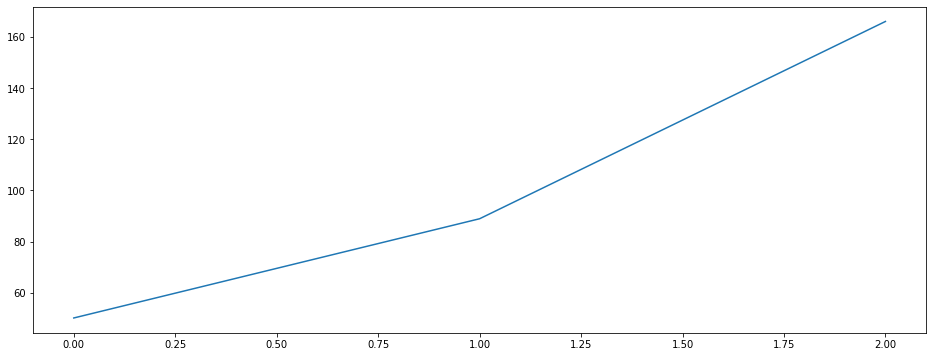

In [155]:
fig, ax = plt.subplots(1, figsize=(16,6))
ax.plot([d5[3], d6[3], d7[3]])

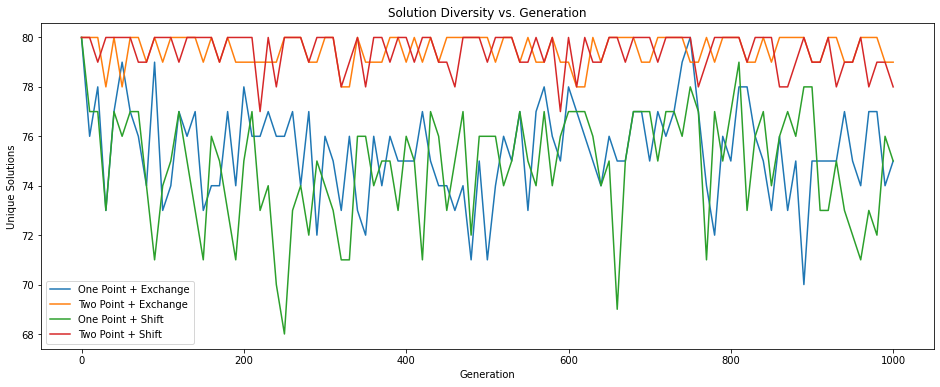

In [122]:
fig, ax = plt.subplots(1, figsize=(16,6))
x_range = [x for x in range(0, 1001, 10)]

ax.plot(x_range, d1[], label=f"One Point + Exchange")
ax.plot(x_range, d2[::10], label=f"Two Point + Exchange")
ax.plot(x_range, d3[::10], label=f"One Point + Shift")
ax.plot(x_range, d4[::10], label=f"Two Point + Shift")
ax.set_title("Solution Diversity vs. Generation")
ax.set_xlabel("Generation")
ax.set_ylabel("Unique Solutions")
plt.legend()
plt.show()

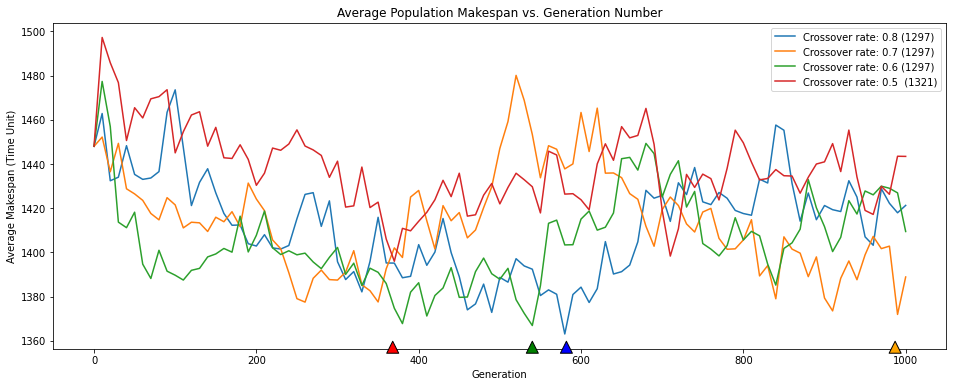

In [151]:
fig, ax = plt.subplots(1, figsize=(16,6))
x_range = [x for x in range(0, 1001, 10)]
ax.plot(x_range, d1[1][::10], label=f"Crossover rate: 0.8 ({d1[0].makespan()})")
ax.plot(x_range, d2[1][::10], label=f"Crossover rate: 0.7 ({d2[0].makespan()})")
ax.plot(x_range, d3[1][::10], label=f"Crossover rate: 0.6 ({d3[0].makespan()})")
ax.plot(x_range, d4[1][::10], label=f"Crossover rate: 0.5  ({d4[0].makespan()})")
sol_hist = [d1[1], d2[1], d3[1], d4[1]]
cols = ['blue', 'orange', 'green', 'red']
for i, sol in enumerate(sol_hist):
    min_y = np.argmin(sol)
    x, y = min_y, 1360
    ax.annotate(f"", xy=(x, y), arrowprops=dict(facecolor=cols[i], shrink=0.05), xytext=(x, y-5))
ax.set_title("Average Population Makespan vs. Generation Number")
ax.set_xlabel(f"Generation")
ax.set_ylabel("Average Makespan (Time Unit)")
ax.legend()
plt.show()


In [15]:
print(min(sol_hist1))
print(min(sol_hist2))
print(min(sol_hist3))
print(min(sol_hist4))

1297
1297
1297
1297


In [20]:
print(s1.jobs)
print(s2.jobs)
print(s3.jobs)
print(s4.jobs)

[8, 15, 1, 19, 5, 4, 2, 9, 3, 6, 7, 12, 11, 13, 17, 18, 16, 14, 10, 20]
[3, 15, 8, 7, 11, 16, 14, 17, 9, 2, 6, 4, 18, 5, 19, 13, 12, 1, 10, 20]
[8, 9, 13, 15, 16, 3, 14, 11, 4, 2, 5, 1, 17, 7, 6, 18, 12, 19, 10, 20]
[15, 11, 8, 9, 17, 1, 18, 5, 16, 14, 3, 6, 19, 7, 4, 2, 13, 12, 10, 20]


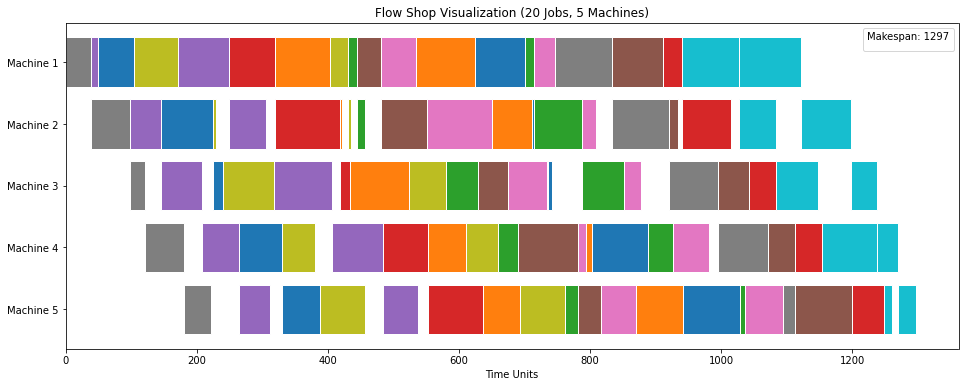

1297


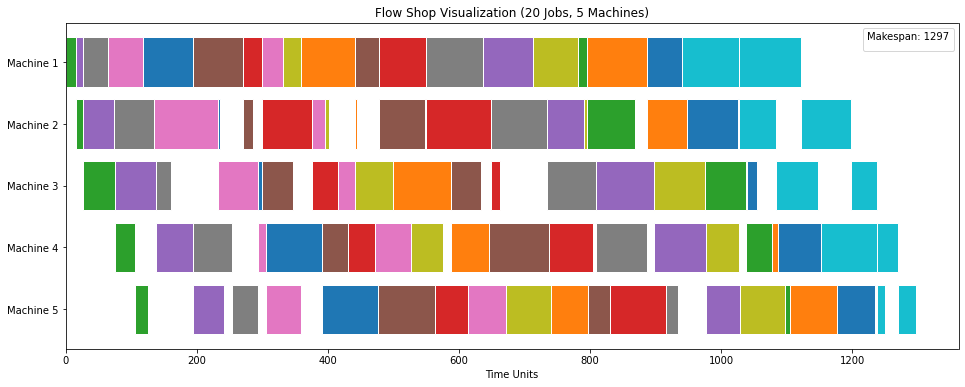

1297


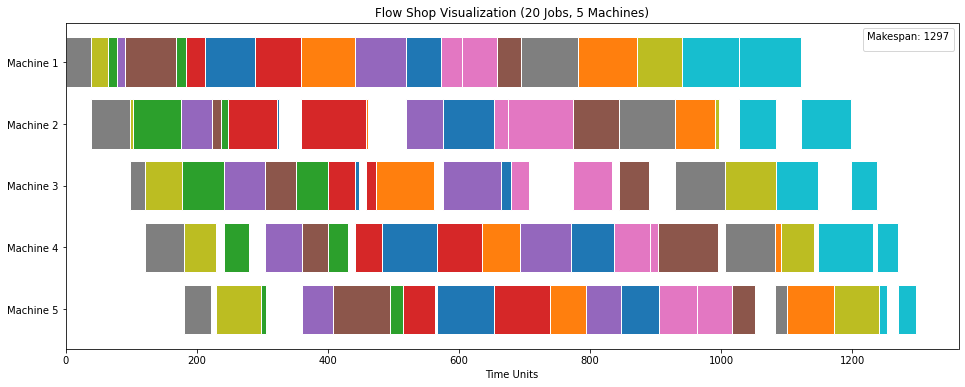

1297


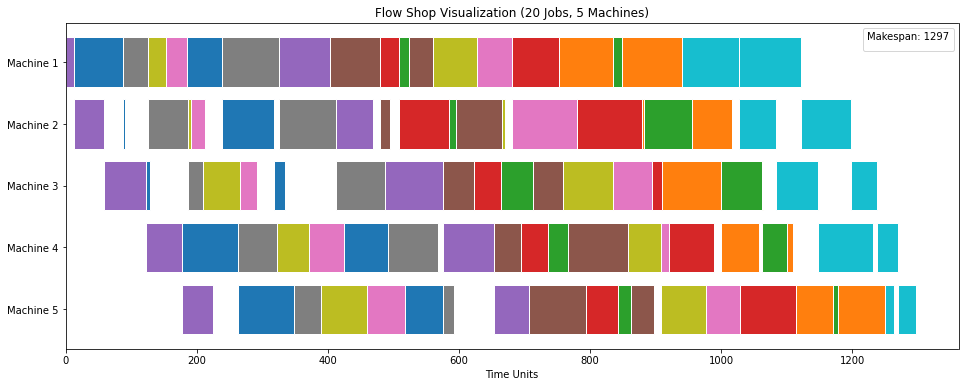

1297


In [17]:
s1.gantt_chart()
s2.gantt_chart()
s3.gantt_chart()
s4.gantt_chart()

|5 6 16 14 2 15 10 17 9 20 13 8 19 12 18 3 4 7 11 1 |


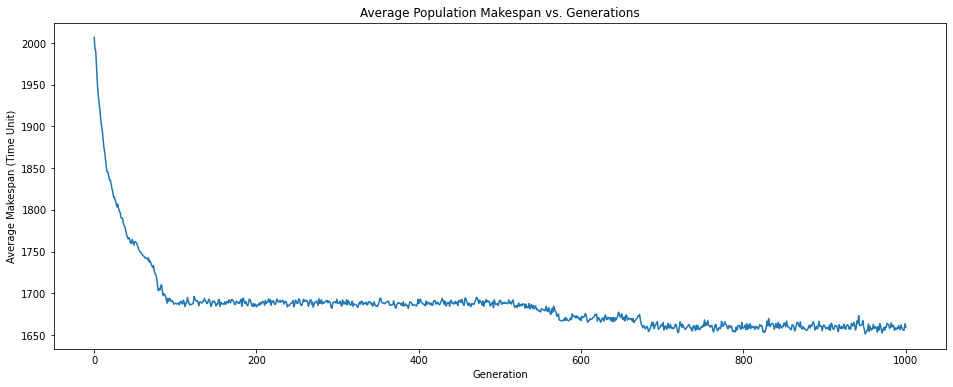

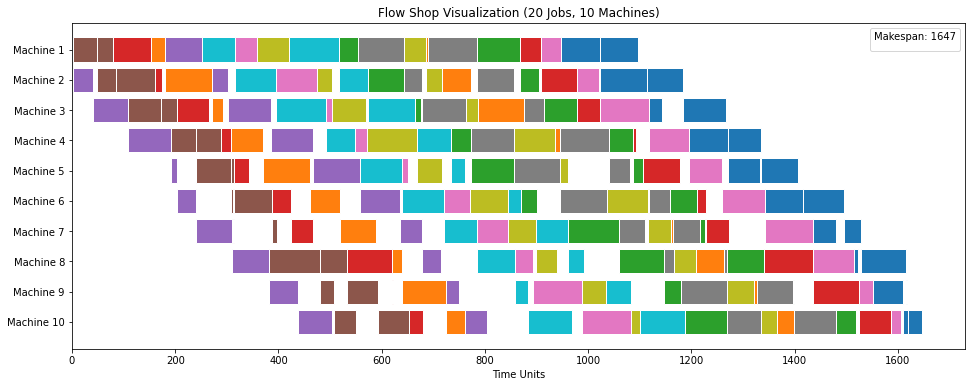

1647


,job,task,start,end,machine,original_id
0,1,1,0.0,3.0,Machine 1,5
1,2,1,3.0,49.0,Machine 1,6
2,3,1,49.0,79.0,Machine 1,16
3,4,1,79.0,154.0,Machine 1,14
4,5,1,154.0,180.0,Machine 1,2
5,6,1,180.0,252.0,Machine 1,15
6,7,1,252.0,315.0,Machine 1,10
7,8,1,315.0,358.0,Machine 1,17
8,9,1,358.0,420.0,Machine 1,9
9,10,1,420.0,517.0,Machine 1,20


In [56]:
fig, ax = plt.subplots(1, figsize=(16,6))
ax.plot(x)
ax.set_title("Average Population Makespan vs. Generations")
ax.set_xlabel("Generation")
ax.set_ylabel("Average Makespan (Time Unit)")

print(s)
s.gantt_chart()
s.get_df().head(50)

In [75]:
p_size = 150
jobs = []
jobs.append(Job([4,2], 1))
jobs.append(Job([5,6], 2))
jobs.append(Job([9,8], 3))
jobs.append(Job([7,1], 4))
jobs.append(Job([3,11], 5))

st = Schedule(jobs, 2)


# df, nums = get_problem("dataset/ta001.txt")
# avg = []
# s = df_to_schedule(df, nums)
# for x in range(50):
#     random_pop = [s.random_copy() for x in range(p_size)]
    

    
    
#     if(x % 100 == 0):
#         print(min([s.makespan() for s in random_pop]))

# avg_roulette = []
# for x in range(500):
#     random_pop = [Schedule(jobs, 2).randomize() for x in range(p_size + 50)]
#     better = GA.roulette_selection(random_pop, 100)
#     assert(len(better) == 100)
#     avg_roulette.append(sum([s.makespan() for s in better])/p_size)
# makespan_hist(avg_roulette)


|1 2 3 4 5 |
|1 2 3 4 5 |
True


Iteration: 0 Current_pop: 100 average_makespan: 33.64
Iteration: 10 Current_pop: 100 average_makespan: 26.81
Iteration: 20 Current_pop: 100 average_makespan: 27.45
Iteration: 30 Current_pop: 100 average_makespan: 26.59
Iteration: 40 Current_pop: 100 average_makespan: 23.77


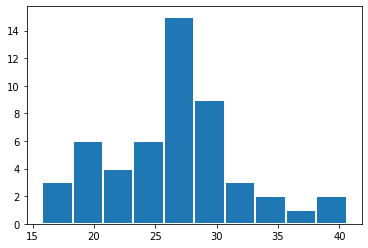

In [413]:
x = run(jobs, 50, p_size, 0.1, 0.8)
makespan_hist(x)

# random

In [370]:
df, nums = get_problem("dataset/ta001.txt")
initial_pop = [df_to_schedule(df, nums).randomize() for x in range(100)]
true = 0
false = 0
for x in range(100):
    better = GA.roulette_selection(initial_pop, 30)
    if(sum([x.makespan() for x in initial_pop[:30]]) > sum([x.makespan() for x in better])):
       true += 1
    else:
       false += 1
print(f"True {true} , False: {false}")

True 32 , False: 68


In [65]:
print(s1.jobs)
GA.shift_mutation(s1, 1)
print(s1.jobs)

[8, 15, 1, 16, 19, 5, 4, 2, 9, 3, 6, 7, 11, 13, 17, 18, 12, 10, 14, 20]
[8, 15, 1, 16, 19, 4, 2, 9, 3, 6, 7, 11, 5, 13, 17, 18, 12, 10, 14, 20]


In [107]:
class GA():
    @staticmethod
    def op_cross(s1, s2):
        j1 = s1.jobs
        j2 = s2.jobs
        child = [0] * len(j1)
        
        # Selecting random index in parent one
        point = randrange(0, len(j1))
        
        LR = bool(getrandbits(1))
        # Going left or right from point to start child gene
        # Left from index
        if(LR):
            child[0:point+1] = j1[0:point+1]
            comp = child[0:point+1]
            empty = [x for x in range(point+1, len(j1))]
        # Right from index
        else:
            child[point:] = j1[point:]
            comp = child[point:]
            empty = [x for x in range(0, point+1)]
        
        index = 0
        # Getting remaining values from second parent, in order
        for i, job in enumerate(j2):
            if job not in comp:
                child[empty[index]] = job
                index += 1
                
        child_s = Schedule(child, s1.m)
            
        return child_s
    
    @staticmethod
    def tp_cross(s1, s2):
        j1 = s1.jobs
        j2 = s2.jobs
        child = [0] * len(j1)
        
        # Selecting two random indexes in parent one
        p1 = randrange(0, len(j1))
        p2 = randrange(0, len(j1))
        
        l = min(p1, p2)
        r = max(p1, p2)
        full = [x for x in range(l, r+1)]
        comp = j1[l:r+1]
        # Going left or right from point to start child gene
        # Left from index
        child[l:r+1] = j1[l:r+1]
                    
        empty_indices = [x for x in range(0, len(j1)) if x not in full]
        
        index = 0     
        for job in j2:
            if job not in comp:
                child[empty_indices[index]] = job
                index += 1
                
        child_s = Schedule(child, s1.m)
            
        return child_s
    
    @staticmethod
    def exchange_mutation(s, prob):
        if(random.random() > prob):
            return
    
        jobs = s.jobs
        
        p1 = randrange(0, len(jobs))
        p2 = randrange(0, len(jobs)) 
        
        jobs[p1], jobs[p2] = jobs[p2] , jobs[p1]
        
        s.jobs = (jobs)
        s.set_makespan()
        
    @staticmethod
    def shift_mutation(s, prob):
        if(random.random() > prob):
            return
    
        jobs = s.jobs
        
        p1 = randrange(0, len(jobs)) 
        p2 = randrange(0, len(jobs)) 
        job = jobs[p1]
        jobs.remove(job)
        jobs.insert(p2, job)
        
        
        s.jobs = (jobs)
        s.set_makespan()
        
    @staticmethod
    def roulette_selection(pop, n):
        total_inv = sum([1./s.makespan() for s in pop])

        selection_probs = [(1./s.makespan())/total_inv for s in pop]

        # Take out least fit individuals
        new_pop = np.random.choice(pop, size=n, replace=False, p=selection_probs)

        return new_pop.tolist()
    
    @staticmethod
    def take_n_best(pop, n):
        sorted_pop = sorted(pop, key=lambda x: x.makespan())
        return sorted_pop[:n]

    # Get index list of sorted fitness
    @staticmethod
    def fitness_indexes(pop):
        fitness_values = []
        for p in pop:
            fitness_values.append(p.makespan())
        return np.argsort(fitness_values)

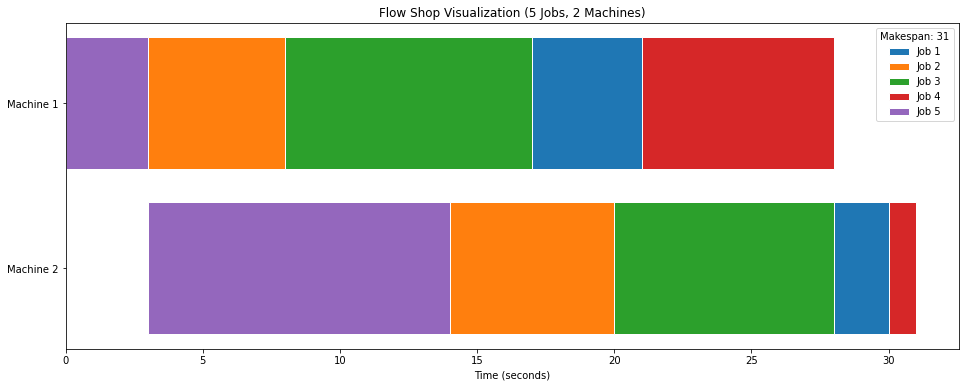

31


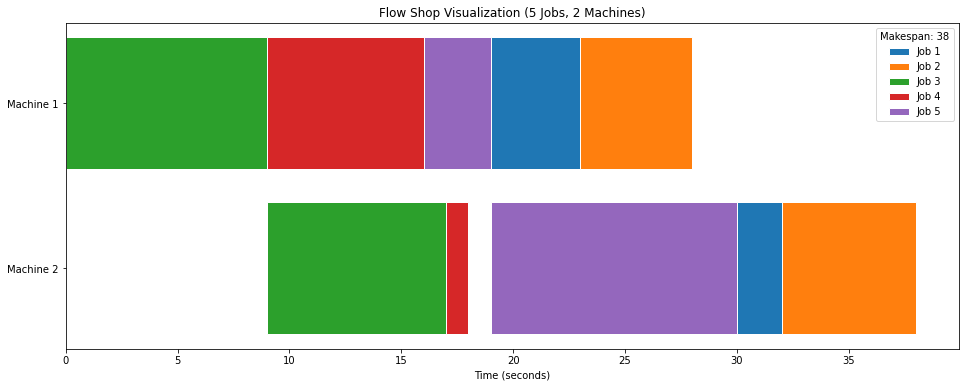

38


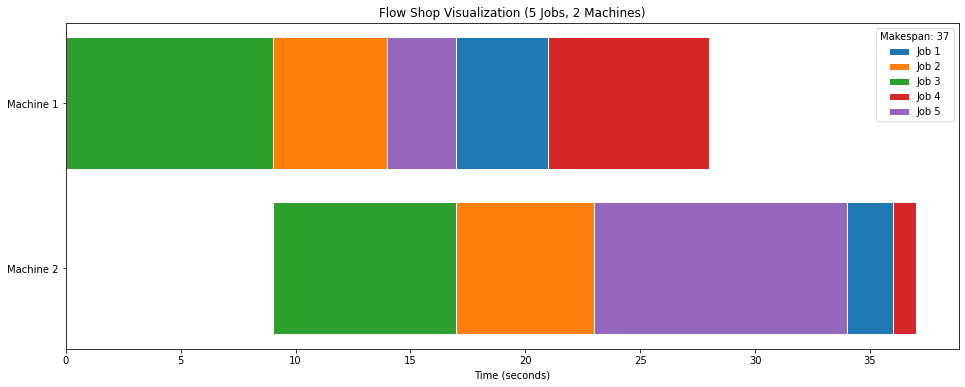

37


In [141]:
jobs = []
jobs.append(Job([4,2], 1))
jobs.append(Job([5,6], 2))
jobs.append(Job([9,8], 3))
jobs.append(Job([7,1], 4))
jobs.append(Job([3,11], 5))

# Reorder jobs in certain order
# Can be used for checking solutions
    

s1 = Schedule(jobs, 2)
s1.reorder([5, 2, 3, 1 , 4])
s1.gantt_chart()

s2 = Schedule(jobs, 2)
s3

s2 = s.random_copy()
s2.gantt_chart()

s3 = s.random_copy()
s3.gantt_chart()

# df, nums = get_problem("dataset/ta120.txt")
# s1 = df_to_schedule(df, nums)
# s2 = df_to_schedule(df, nums)
# # Fast makespan
# # print(s.fast_makespan())
# # print(s.makespan())
# # print(s.jobs)
# s1.randomize()
# print(s1.makespan())
# print(s2.makespan())

In [118]:
s2.get_df().head(20)

,job,task,start,end,machine,original_id
0,1,1,0.0,4.0,Machine 1,1
1,2,1,4.0,7.0,Machine 1,5
2,3,1,7.0,14.0,Machine 1,4
3,4,1,14.0,19.0,Machine 1,2
4,5,1,19.0,28.0,Machine 1,3
5,1,2,4.0,6.0,Machine 2,1
6,2,2,7.0,18.0,Machine 2,5
7,3,2,18.0,19.0,Machine 2,4
8,4,2,19.0,25.0,Machine 2,2
9,5,2,28.0,36.0,Machine 2,3


In [108]:
class Schedule():
    def __init__(self, jobs, num_machines):
        self.jobs = jobs
        
        self.m = num_machines
        self.makespan_matrix = None
        self.set_makespan()
        
        

    def set_makespan(self):
        # Num machines x Num Jobs
        end_times = np.zeros((self.m, len(self.jobs)))

        end_times[0][0] = self.jobs[0].tasks[0].length
        for i in range(1, len(self.jobs)):
            end_times[0][i] = end_times[0][i-1] + self.jobs[i].tasks[0].length

        for x in range(1, self.m):
            for y, job in enumerate(self.jobs):
#                 print(job)
                if (y ==0):
                    end_times[x][y] = end_times[x-1][y] + job.tasks[x].length
                else:
                    prereq_end = end_times[x-1][y]

                    prev_task_end = end_times[x][y-1]
#                     print(fprereq_end, prev_task_end)

                    end_times[x][y] = max(prereq_end, prev_task_end) + job.tasks[x].length

        self.makespan_matrix = end_times
            
    def makespan(self):
        return int(self.makespan_matrix[-1][-1])
                
    def reorder(self, order):
        temp = [0] * len(order)
        for i, job_num in enumerate(order):
            temp[i] = self.jobs[job_num-1]
        self.jobs = temp
        self.set_makespan()
            
#     def set_permutation(self):
#         self.machines = []
#         for m in range(self.m):
#             self.machines.append([])
#             for i, job in enumerate(self.jobs):
#                 if(job.n > m):
#                     self.machines[m].append(job.tasks[m])
#         self.update_times()
        
    def randomize(self):
        shuffle(self.jobs)
        self.set_makespan()
        return self
    
    def random_copy(self):
        s = Schedule(self.jobs, self.m)
        s = s.randomize()
        return s
        
        
         
#     def update_times(self):
#         self.makespan_matrix = None
#         # First operation on each
#         track = self.machines[0]
#         track[0].set_start(0)
#         for i in range(1, len(track)):
#             track[i].set_start(track[i-1].end)
             
#         for machine in self.machines[1:]:
#             for i, task in enumerate(machine):
#                 if i == 0:
#                     task.set_start(task.parent.end)
#                 else:
#                     #start is the max of parent.end and i-1 End
#                     legal_start = max(task.parent.end, machine[i-1].end)
#                     task.set_start(legal_start)
        
    def print_times(self):
        for machine in self.machines:
            track_schedule = ""
            for task in machine:
                track_schedule += f"{task.start} - {task.end} |"
            print(track_schedule)
            
    def get_df(self):
        df = {"job" : [], "task": [],  "start": [], "end": [], "machine": [], "original_id" : []}
        count = 1
        for task_id, row in enumerate(self.makespan_matrix):
            for job_id, end_time in enumerate(row):
                df["job"].append(job_id+1)
                df["task"].append(task_id+1)
                df["start"].append(end_time - self.jobs[job_id].tasks[task_id].length)
                df["end"].append(end_time)
                df["machine"].append(f"Machine {task_id+1}")
                df["original_id"].append(self.jobs[job_id].ID)
                count += 1
        return pd.DataFrame(data=df)

    
    def __repr__(self):
        rep = "|"
        for job in self.jobs:
            rep += str(job) + " "
        return rep + "|"
    
    def gantt_chart(self):
        df = self.get_df()
#     df['color'] = df.apply(color, axis=1)
#     legend_elements = [Patch(facecolor=c_dict[i], label=i)  for i in c_dict]
        df['width'] = (df.end-df.start)
        fig, ax = plt.subplots(1, figsize=(16,6))
        df = df.reset_index()  # make sure indexes pair with number of rows
        for job_num in range(1, len(self.jobs)+1):
            row = df.loc[df['original_id'] == job_num]
            ax.barh(row['machine'], row['width'], left=row['start'], edgecolor='white', label=f"Job {job_num}")
            
        # Y axis Labels
        y_labels = []
        for i in range(1, self.m+1):
            y_labels.append(f"Machine {i}")
        ax.set_yticks(y_labels)
        ax.invert_yaxis()
        
        ax.set_title(f"Flow Shop Visualization ({len(self.jobs)} Jobs, {self.m} Machines)")
        ax.set_xlabel("Time Units")
        
        if(len(self.jobs) <= 10):
            plt.legend(title=f'Makespan: {round(self.makespan_matrix[-1][-1])}')
        else:
            plt.legend([], title=f'Makespan: {round(self.makespan_matrix[-1][-1])}' )
        plt.show()
        print(self.makespan())
                    

    def __eq__(self, other):
        return str(self) == str(other)
    
    def __hash__(self):
        return hash(str(self))

class Job():
    def __init__(self, length_per_task, job_id=-1):
        self.n = len(length_per_task)
        self.tasks = []
        self.start = 0
        self.end = 0
        self.ID = job_id
        #Linked list of task hierarchy
        for i, length in enumerate(length_per_task):
            self.tasks.append(Task(None, length, (job_id, i)))
        for i in range(1, len(self.tasks)):
            self.tasks[i].parent = self.tasks[i-1]
            
    def __hash__(self):
        return self.ID
    
    def __eq__(self, other):
        return self.ID == other.ID
    
    def __str__(self):
        return str(self.ID)
    
    def __repr__(self):
        return str(self.ID)

class Task():
    def __init__(self, parent, length, ID = None):
        self.parent = parent # Task that preceedes this
        self.length = length # How long task will take
        self.ID = ID
        
    def __str__(self):
        return str(self.ID)
    
    def set_start(self, start):
        self.start = start
        self.end = start + self.length